# Loading libraries and data

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from datetime import datetime, timedelta
from scipy import stats
from tqdm.auto import tqdm, trange
from networkx.algorithms import bipartite
from matplotlib.dates import (
    AutoDateLocator, date2num
)
from pprint import pprint
from dateutil.relativedelta import relativedelta

In [2]:
g = nx.read_gexf('../graph.gexf')
assert bipartite.is_bipartite(g)

# Preprocessing

## Removing suspended mods 

In [3]:
suspended_mods = []
for n, d in g.nodes(data=True):
    if d["bipartite"] == 0 and d['is_suspended'] == True:
        suspended_mods.append(n)

In [4]:
n_suspended = len(suspended_mods)
n_mods = len([n for n, d in g.nodes(data=True) if d['bipartite'] == 0])
pct_suspended = n_suspended / n_mods * 100
print(f"Removing {n_suspended} ({pct_suspended:.2f}%) suspended mods")
g.remove_nodes_from(suspended_mods)

Removing 609 (1.97%) suspended mods


## Removing inactive mods

In [5]:
activ_ts = [d['last_active'] for _, d in g.nodes(data=True) if d["bipartite"] == 0]
activ_ts = pd.to_datetime(activ_ts, unit='s')
activ_ts = activ_ts.dropna()

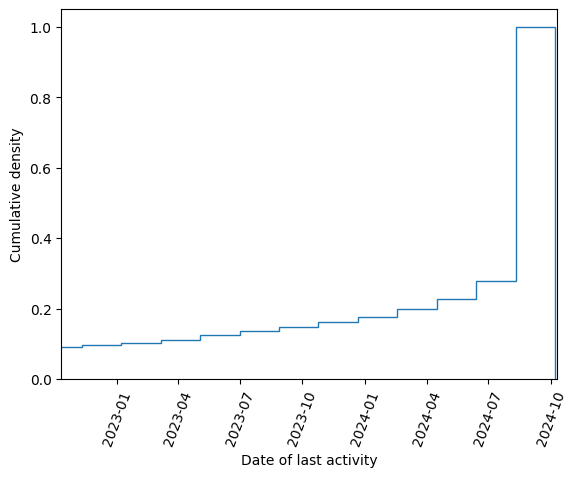

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(
    date2num(activ_ts),
    bins=100,
    cumulative=True,
    density=True,
    histtype="step"
)
ax.xaxis_date()
ax.xaxis.set_major_locator(
    AutoDateLocator(minticks=3, interval_multiples=False)
)
ax.set_ylabel('Cumulative density')
ax.set_xlabel('Date of last activity')
plt.xticks(rotation=70)

s = datetime.now()
ax.set_xlim([s - relativedelta(years=2), s]);

In [7]:
cutoff = datetime.now() - relativedelta(months=3)
percentile = sum(activ_ts > cutoff) / len(activ_ts)
print(f"{percentile * 100:.2f}% of moderators were active in the last three months")

75.28% of moderators were active in the last three months


In [8]:
inactive_mods = []
for n, d in g.nodes(data=True):
    if d["bipartite"] == 1:
        continue
    if pd.isnull(d['last_active']):
        inactive_mods.append(n)
        continue
    last_ts = datetime.fromtimestamp(d['last_active'])
    if last_ts < cutoff:
        inactive_mods.append(n)

In [9]:
n_inactive = len(inactive_mods)
n_mods = len([n for n, d in g.nodes(data=True) if d['bipartite'] == 0])
pct_inactive = n_inactive / n_mods * 100
print(f"Removing {n_inactive} ({pct_inactive:.2f}%) inactive mods")
g.remove_nodes_from(inactive_mods)

Removing 8062 (26.58%) inactive mods


## Removing super-mods 

Let's try to identify supermods. If they moderate many subs that they can't possibly pay attention to all of them. Edges due to them aren't meaningful.

In [10]:
mod_nodes = {n for n, d in g.nodes(data=True) if d["bipartite"] == 0}

In [11]:
n_moderated = [len(g.edges(n)) for n in mod_nodes]

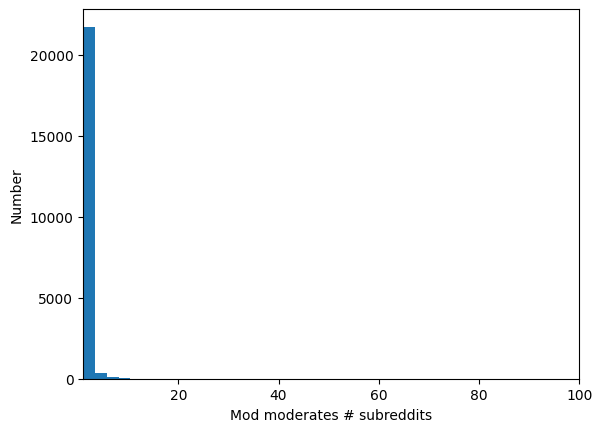

In [12]:
plt.hist(n_moderated, bins=1000)
plt.xlim([1, 100])
plt.xlabel("Mod moderates # subreddits")
plt.ylabel("Number");

In [13]:
stats.percentileofscore(n_moderated, 10)

99.73733836206895

Let's remove all modes that moderate over 10 subs.

In [14]:
cutoff = 10
super_mods = {n for n in mod_nodes if len(g.edges(n)) > cutoff}
n_super = len(super_mods)
n_mods = len([n for n, d in g.nodes(data=True) if d['bipartite'] == 0])
pct_super = n_super / n_mods * 100
print(f"Removing {n_super} ({pct_super:.2f}%) super mods")
g.remove_nodes_from(super_mods)

Removing 56 (0.25%) super mods


## Projecting bipartite graph

Many standard algorithms are unsuited for bipartite graphs and don't accurately capture its topology. I will project the graph to a one-mode graph consisting of subreddits only. In order to properly weigh the edges, I will be using the resource-allocation algorithm described in ["Bipartite network projection and personal recommendation" by Zhou et al. (2007)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.046115). Basically,

$$
w_{ij} = \frac{1}{k(x_j)}\sum_{l=1}^{m}\frac{a_{il}a_{jl}}{k(y_l)}
$$

where $a_{ij}$ is the adjacency matrix, and $k(\cdot)$ returns the degree of a node. Because the resulting coefficient is not symmetrical, I take
$$
w_{(ij)} = \frac{1}{2}\left[w_{ij} + w_{ji}\right]
$$

to be the weight of the projected undirected graph.

For example,
<div>
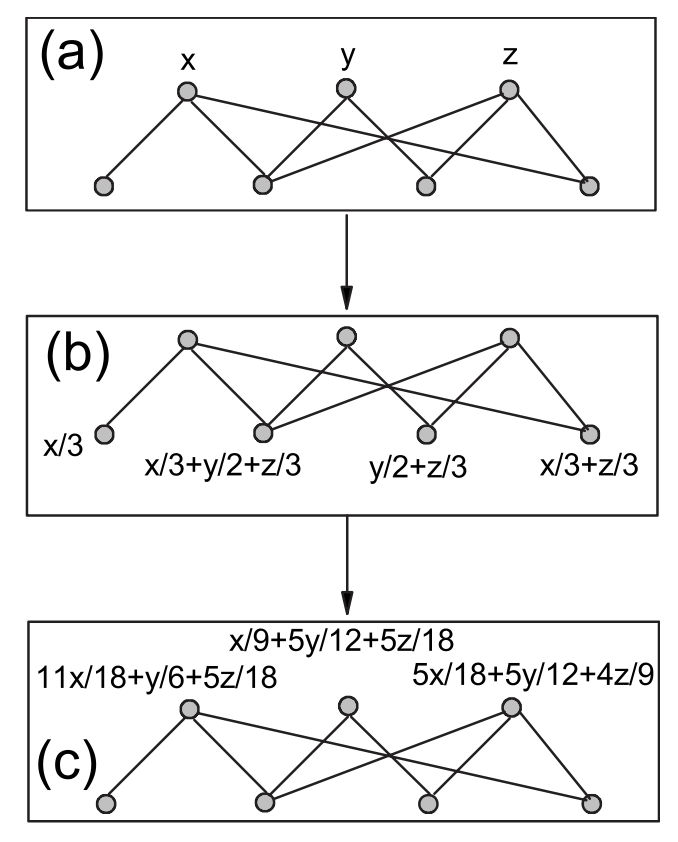
</div>

Therefore, $$\mathbf{w} =
\begin{equation}
\begin{pmatrix}
  11/18 & 1/6 & 5/18 \\
  1/9 & 5/12 & 5/18 \\
  5/18 & 5/12 & 4/9
\end{pmatrix}
\end{equation}
$$

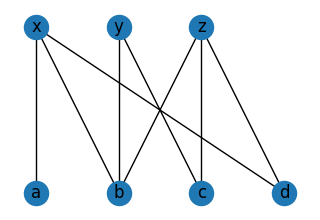

In [18]:
g_test = nx.Graph()
g_test.add_nodes_from(['x', 'y', 'z'])
g_test.add_nodes_from(['a', 'b', 'c', 'd'])
g_test.add_edges_from([
    ('x', 'a'), ('x', 'b'), ('x', 'd'),
    ('y', 'b'), ('y', 'c'),
    ('z', 'b'), ('z', 'c'), ('z', 'd')
])

plt.figure(figsize=(3, 2))
subs, mods = bipartite.sets(g_test)
pos = dict()
pos.update((n, (i, 2)) for i, n in enumerate(['x', 'y', 'z']))
pos.update((n, (i, 1)) for i, n in enumerate(['a', 'b', 'c', 'd']))
nx.draw(g_test, pos=pos, with_labels=True)

In [19]:
def get_proj_weights(g, proj_nodes):
    adj = bipartite.biadjacency_matrix(g, row_order=proj_nodes).toarray()
    adj_cols = adj.sum(axis=0, dtype='float64', keepdims=True) + 1e-8 #for num stability
    adj_rows = adj.sum(axis=1, dtype='float64', keepdims=True) + 1e-8 #for num stability
    return (adj / adj_cols) @ (adj / adj_rows).T

In [20]:
proj_weights_test = np.array([
    [11/18, 1/6, 5/18],
    [1/9, 5/12, 5/18],
    [5/18, 5/12, 4/9]
])
assert np.allclose(get_proj_weights(g_test, ['x', 'y', 'z']), proj_weights_test)

Now let's apply this to our Reddit graph and project it to both users and mods:

In [21]:
all_subs = [n for n, d in g.nodes(data=True) if d['bipartite'] == 1]
sub_weights = get_proj_weights(g, all_subs)
#making symmetrical
sub_weights = (sub_weights + sub_weights.T) / 2

In [22]:
all_mods = [n for n, d in g.nodes(data=True) if d['bipartite'] == 0]
mod_weights = get_proj_weights(g, all_mods)
#making symmetrical
mod_weights = (mod_weights + mod_weights.T) / 2

In [23]:
sub2idx = {n: i for i, n in enumerate(all_subs)}
mod2idx = {n: i for i, n in enumerate(all_mods)}

In [29]:
def mod_weight_function(g, mod1, mod2):
    i1, i2 = mod2idx[mod1], mod2idx[mod2]
    return mod_weights[i1, i2]

def sub_weight_function(g, sub1, sub2):
    i1, i2 = sub2idx[sub1], sub2idx[sub2]
    return sub_weights[i1, i2]

In [31]:
g_subproj = bipartite.generic_weighted_projected_graph(g, all_subs, sub_weight_function)
g_modproj = bipartite.generic_weighted_projected_graph(g, all_mods, mod_weight_function)

In [32]:
nx.write_gexf(g_subproj, 'graph_proj2subs.gexf')
nx.write_gexf(g_modproj, 'graph_proj2mods.gexf')

# Exploration

## Bots

The procedure to identify bots was quite simple (a sequence of regex patterns matching the username and the last comment the user made). There might be false positives/negatives, and yet it's interesting to explore.

In [15]:
mod_nodes = [n for n, d in g.nodes(data=True) if d['bipartite'] == 0]
bot_nodes = [n for n, d in g.nodes(data=True) if d['bipartite'] == 0 and d['is_bot'] == True]
print(f"{len(bot_nodes)} bots ({len(bot_nodes)/len(mod_nodes)*100:.2f} % of mods)")

274 bots (1.23 % of mods)


In [16]:
n_mod_edges = len(g.edges(mod_nodes))
n_bot_edges = len(g.edges(bot_nodes))
print(f"Mod nodes account for {n_bot_edges/n_mod_edges*100:.2f}% of edges")

Mod nodes account for 1.32% of edges


So overall bot moderators are quite numerically insignificant.

## Topological features of projected graph

### Isolated components

Our graph is split into isolated connected components.

In [99]:
isolates = list(nx.connected_components(g))
len(isolates)

1924

In [100]:
all_subs = {n for n, d in g.nodes(data=True) if d['bipartite'] == 1}
print(len(all_subs))

def count_subs(iso):
    return sum(1 for n in iso if n in all_subs)

isolates_size = sorted([count_subs(iso) for iso in isolates], reverse=True)
isolates_size[0], isolates_size[1], isolates_size[2], sum(isolates_size[1:])

4386


(2205, 11, 10, 2181)

So we have 1'923 isolated components. The giant component comprises `2'205/4'386=50.3%` of all subs. The remaining components are much smaller: the second-largest has only 11 subs.

In [102]:
idx_isolate = 1
nodes_isolate = sorted(isolates, key=count_subs, reverse=True)[idx_isolate]
subs_isolate = [n for n in nodes_isolate if n in all_subs]
print(f"Subreddits in isolate #{idx_isolate + 1}:")
print('\n * ' + '\n * '.join(subs_isolate))

Subreddits in isolate #2:

 * biggboss
 * StartUpIndia
 * arcteryx
 * Silverbugs
 * AskIndia
 * unitedstatesofindia
 * BollyBlindsNGossip
 * IndiaTax
 * Gold
 * bollywood
 * indiasocial


In [103]:
idx_isolate = 2
nodes_isolate = sorted(isolates, key=count_subs, reverse=True)[idx_isolate]
subs_isolate = [n for n in nodes_isolate if n in all_subs]
print(f"Subreddits in isolate #{idx_isolate + 1}")
print('\n * ' + '\n * '.join(subs_isolate))

Subreddits in isolate #3

 * pixel_phones
 * casio
 * iOSProgramming
 * 23andme
 * TeslaModel3
 * gsuite
 * ModelY
 * teslamotors
 * TeslaLounge
 * elonmusk


The 2nd and 3rd largest isolated components are subs relating to India and tech companies, respectively.

### Standard statistics and comparison to other datasets

In [58]:
g_proj = nx.projected_graph(g, all_subs)
print(f"V = {len(g_proj.nodes())}, E = {len(g_proj.edges())}")

g_proj = nx.projected_graph(g, all_subs)
e = nx.global_efficiency(g_proj)
print(f'e (efficiency) = {e:.3f}')

g_proj = nx.projected_graph(g, all_subs)
#removing nodes with degree 1
remove = [n for n, d in dict(g_proj.degree()).items() if d < 2]
g_proj.remove_nodes_from(remove)
cc = nx.average_clustering(g_proj)
print(f'c (clustering coefficient) = {cc:.3f}')

g_proj = nx.projected_graph(g, all_subs)
r = nx.degree_assortativity_coefficient(g_proj)
print(f'r (assortativity coefficient) = {r:.3f}')

g_proj = nx.projected_graph(g, all_subs)
r = nx.attribute_assortativity_coefficient(g_proj, attribute='size')
print(f'r_size (size assortativity coefficient) = {r:.3f}')

g_proj = nx.projected_graph(g, all_subs)
degrees = np.array(list(dict(g_proj.degree()).values()))
H = np.mean(degrees ** 2) / np.mean(degrees) ** 2
print(f'H (degree heterogeneity) = {H:.3f}')

V = 4386, E = 6976
e (efficiency) = 0.055
c (clustering coefficient) = 0.568
r (assortativity coefficient) = 0.169
r_size (size assortativity coefficient) = -0.001
H (degree heterogeneity) = 4.121


Values for other datasets are taken from ["Predicting Missing Links via Local Information" by Zhou et al. (2009)](https://arxiv.org/abs/0901.0553). Let's compare our (projected) graph to other known datasets:

* PPI – protein-protein interactions
* NS - coatuhorships between scientists
* Grid – electrical power grid of western US
* PB – network of US political blogs
* INT – router-level topology of the Internet
* USAir – network of US air transportation system

|            | $N$    | $E$    | $N_c$       | $e$     | $C$     | $r$     | $H$     |
|------------|------|------|-----------|-------|-------|-------|-------|
| PPI | 2617 | 11855 | 2375/92 | 0.180 | 0.387 | 0.461 | 3.73 |
| NS | 1461 | 2742 | 379/268 | 0.016 | 0.878 | 0.462 | 1.85 |
| Grid | 4941 | 6594 | 4941/1 | 0.063 | 0.107 | 0.003 | 1.45 |
| PB | 1224 | 19090 | 1222/2 | 0.397 | 0.361 | -0.079 | 3.13 |
| INT | 5022 | 6258 | 5022/1 | 0.167 | 0.033 | -0.138 | 5.50 |
| USAir | 332 | 2126 | 332/1 | 0.406 | 0.749 | -0.208 | 3.46 |
| **RedditMods (proj)** | **4386** | **7002** | **2205/1924** | **0.055** | **0.568** | **0.174** | **4.143** |

We can draw the following conclusions:
* The network is moderately well connected, and has a large giant component.
* Subreddits are highly clustered, i.e. two subreddits that share a neighboring vertex in common are likely to be neighbors too. 
* The assortative coefficient is small but positive. Therefore, those subreddits that have many moderators are often moderated by the same people.

## Computing Resistance Distance

My strategy is as follows. I will be using [Resistance Distance](https://en.wikipedia.org/wiki/Resistance_distance) to rank subs in order of relevance.

However, computing the resistance distance is slow, so instead of running it on the whole graph, I will select a group of nodes around my subreddit of interest (aka the **locality**). I will then rank those candidates using the resistance distance as a metric.

In [12]:
def get_locality(path_lengths, s0, max_loc_size):
    #increasing maximum path length from s0 to nodes until I reach my desired locality size
    max_length = 0
    curr_locality = [s0]
    next_locality = [u for u in path_lengths if path_lengths[u] < max_length * 2]
    
    while len(next_locality) < max_loc_size and len(next_locality) < len(path_lengths):
        max_length += 1
        curr_locality = next_locality
        next_locality = [u for u in path_lengths if path_lengths[u] < max_length * 2]

    return curr_locality

## Bipartite Graph

Let's explore an interesting subreddit called [r/hebrew](https://www.reddit.com/r/hebrew).

In [13]:
s0 = 'hebrew'

In [14]:
path_lengths = nx.shortest_path_length(g, source=s0)
locality = get_locality(path_lengths, s0, max_loc_size=5000)

In [15]:
#a subgraph covering our locality
g_local = g.subgraph(locality)

In [16]:
%time res_dist = nx.resistance_distance(g_local, nodeA=s0, weight='conductivity')

CPU times: user 1min 21s, sys: 22.9 s, total: 1min 44s
Wall time: 15.5 s


Now let's select the nodes.

In [17]:
mod_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 0}
sub_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 1}

Because `sorted` is a stable sort, we can priorize nodes by degree of separation, while sort nodes within each "shell" using the resistance distance.

In [18]:
candidate_subs = [k for k in res_dist.keys() if k in sub_nodes]
#`sorted` is a stable sort
candidate_subs = sorted(candidate_subs, key=res_dist.get)
candidate_subs = sorted(candidate_subs, key=path_lengths.get)
#keeping top-15
candidate_subs = candidate_subs[:15]

In [19]:
candidate_mods = list()
for mod in mod_nodes:
    inter = set(g.neighbors(mod)) &  set(candidate_subs)
    if len(inter) > 1:
        candidate_mods.append(mod)

We next write out our graph and visualise it in Gephi.

In [20]:
candidate_nodes = candidate_subs + candidate_mods
nx.write_gexf(g_local.subgraph(candidate_nodes), 'example-bipartite.gexf')

The result:

<div>
<img src="example-bipartite.png" width="700"/>
</div>

## Projected Graph

We can also project the bipartite graph, and display only subreddits, while omitting the mods.

In [21]:
s0 = 'Palestine'

path_lengths = nx.shortest_path_length(g, source=s0)
locality = get_locality(path_lengths, s0, max_loc_size=5000)

#a subgraph covering our locality
g_local = g.subgraph(locality)

mod_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 0}
sub_nodes = {n for n, d in g_local.nodes(data=True) if d["bipartite"] == 1}

In [22]:
%time res_dist = nx.resistance_distance(g_local, nodeA=s0, weight='conductivity')

CPU times: user 18.2 s, sys: 7.19 s, total: 25.4 s
Wall time: 4.13 s


In [23]:
candidate_subs = [k for k in res_dist.keys() if k in sub_nodes]
#`sorted` is a stable sort
candidate_subs = sorted(candidate_subs, key=res_dist.get)
candidate_subs = sorted(candidate_subs, key=path_lengths.get)
#keeping top-30
candidate_subs = candidate_subs[:30]

In [24]:
#projecting graph onto subreddits
g_local_subs = bipartite.weighted_projected_graph(g_local, sub_nodes)

In [25]:
nx.write_gexf(g_local_subs.subgraph(candidate_subs), 'example-projected.gexf')

The result, visualised in Gephi:

* The more members there are in a subreddit, the larger the node
* Nodes are coloured by the degree of separation from `s0`: 0 is red, 1 is pink, 2 is blue

<div>
<img src="example-projected.png" width="800"/>
</div>